# Testing different dynamical systems-inspired training strategies for RNNs and NeuralODEs

We will start out by using the Lorenz63 system:

\begin{aligned}
&\dot{x} = \sigma(y-x)\\
&\dot{y} = x(\rho-z)-y\\
&\dot{z} = xy-\beta z
\end{aligned}

with the parameters $\sigma = 10, \beta = 8/3, \rho = 28$ chosen so that the system displays chaotic behavior.

Following Hess et al. Generalized Teacher Forcing for Learning Chaotic Dynamics, ICML (2023)., the train and test sets are each comprised of a single trajectory 
with initial condition chosen as $\boldsymbol{u_0} = (x_0, y_0, z_0)^T \sim \mathscr{N}(\boldsymbol{0}, \boldsymbol{I})$ with $t=\{i\Delta t\}_{i=0}^{N-1}$ with $\Delta t = 0.01$ and $N=10^5$.

The training set is contaminated with Gaussian observation noise corresponding to 5% of the data standard deviation.

In [ ]:
from collections.abc import Callable
from functools import partial

import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from dynamical_systems.lorenz import Lorenz63
from jaxtyping import Array, Float
from matplotlib_utils.axes_setters import set_labels


jax.config.update("jax_enable_x64", True)

In [ ]:
lorenz = Lorenz63()


@eqx.filter_jit
def solve_ode(
    ode: Callable,
    t: Float[Array, " N"],
    u0: Float[Array, " D"],
    solver: dfx.AbstractAdaptiveSolver = dfx.Tsit5(),
    rtol: float = 1e-4,
    atol: float = 1e-4,
    **diffeqsolve_kwargs,
) -> Float[Array, "N D"]:
    sol = dfx.diffeqsolve(
        dfx.ODETerm(ode),
        solver,
        t[0],
        t[-1],
        None,
        u0,
        saveat=dfx.SaveAt(ts=t),
        stepsize_controller=dfx.PIDController(rtol=rtol, atol=atol),
        **diffeqsolve_kwargs,
    )
    return sol.ys


key = jax.random.PRNGKey(0)
u0_train_test = jax.random.normal(key, shape=(2, 3))

dt = 0.01
t = jnp.arange(1e5) * dt
solve_lorenz = partial(solve_ode, lorenz.rhs, t, max_steps=None)

u_train_test = eqx.filter_vmap(solve_lorenz)(u0_train_test)

In [3]:
u_train_mean = jnp.mean(u_train_test[0], axis=0)
u_train_std = jnp.std(u_train_test[0], axis=0)
u_train_test_norm = (u_train_test - u_train_mean) / u_train_std

u_train, u_test = u_train_test_norm

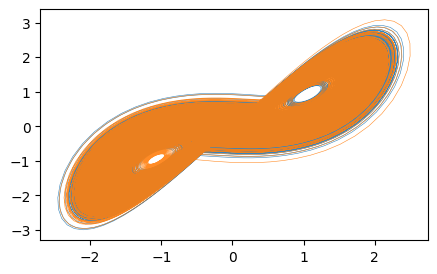

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_kwargs = {"linewidth": 0.4, "alpha": 0.9}
ax.plot(u_train[:, 0], u_train[:, 1], **plot_kwargs)
ax.plot(u_test[:, 0], u_test[:, 1], **plot_kwargs)

In [5]:
class NeuralODE(eqx.Module):
    in_size: int
    width_size: int
    depth: int
    out_size: int | None = None
    activation: Callable = jax.nn.gelu
    key: int = 0
    net: eqx.nn.MLP = eqx.field(init=False)

    def __post_init__(self):
        if self.out_size is None:
            self.out_size = self.in_size
        self.net = eqx.nn.MLP(
            in_size=self.in_size,
            out_size=self.out_size,
            width_size=self.width_size,
            depth=self.depth,
            activation=self.activation,
            key=jax.random.PRNGKey(self.key),
        )

    def rhs(self, t, u, args):
        del t, args
        return self.net(u)

In [6]:
def split_into_chunks(
    sequence: Float[Array, " N"], chunk_size: int
) -> tuple[Float[Array, "B N"], Float[Array, " N_remainder"] | None]:
    # TODO: Handle batch dimension in the sequence argument
    # TODO: Implement the case when there are overlaps between chunks, as specified by the overlap: int parameter
    chunks = jnp.split(sequence, jnp.arange(chunk_size, len(sequence), chunk_size))
    if len(chunks[-2]) == len(chunks[-1]):
        batched_chunks = jnp.stack(chunks, axis=0)
        remainder = None
    else:
        batched_chunks = jnp.stack(chunks[:-1], axis=0)
        remainder = chunks[-1]
    return batched_chunks, remainder


chunk_length = 77
t_train_batched, remainder = split_into_chunks(t, chunk_length)
u_train_batched, remainder = split_into_chunks(u_train, chunk_length)
# assert remainder is None, (
#     "Chunk size does not cleanly divide the sequence into equal-length chunks!"
# )
u_train_batched.shape

(1298, 77, 3)

In [7]:
neuralode = NeuralODE(3, 32, 3)


@eqx.filter_jit
@partial(eqx.filter_vmap, in_axes=(None, 0, 0))
def solve_neuralode(model, t, u0):
    u_pred = solve_ode(
        model.rhs,
        t,
        u0,
        max_steps=2048,
        adjoint=dfx.RecursiveCheckpointAdjoint(checkpoints=4096),
    )
    return u_pred


u_pred = solve_neuralode(neuralode, t_train_batched, u_train_batched[:, 0])

In [8]:
u_pred.shape

(1298, 77, 3)

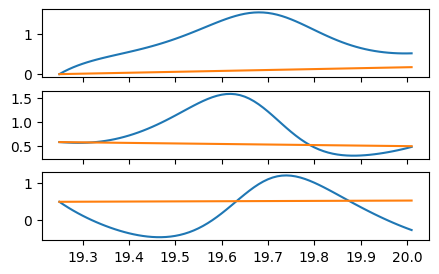

In [9]:
chunk_idx = 25
fig, axes = plt.subplots(3, 1, figsize=(5, 3), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(t_train_batched[chunk_idx], u_train_batched[chunk_idx, :, i])
    ax.plot(t_train_batched[chunk_idx], u_pred[chunk_idx, :, i])

In [10]:
@eqx.filter_value_and_grad
def loss_grad(
    model, t_data: Float[Array, "batch time"], u_data: Float[Array, "batch time dim"]
):
    u_pred = solve_neuralode(model, t_data, u_data[:, 0])
    return jnp.mean((u_pred - u_data) ** 2)


lr = 1e-3
optim = optax.adabelief(lr)
opt_state = optim.init(eqx.filter(neuralode, eqx.is_inexact_array))


def make_step(t_data, u_data, model, opt_state):
    loss, grads = loss_grad(model, t_data, u_data)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [11]:
max_steps = 5000
model = neuralode
loss_history = []
for step in range(max_steps):
    loss, model, opt_state = make_step(
        t_train_batched, u_train_batched, model, opt_state
    )
    print(f"{step=}, {loss=}")
    loss_history.append(loss.item())

step=0, loss=Array(1.35030745, dtype=float64)
step=1, loss=Array(1.34798011, dtype=float64)
step=2, loss=Array(1.34558643, dtype=float64)
step=3, loss=Array(1.34311819, dtype=float64)
step=4, loss=Array(1.34056507, dtype=float64)
step=5, loss=Array(1.3379136, dtype=float64)
step=6, loss=Array(1.33514539, dtype=float64)
step=7, loss=Array(1.33223634, dtype=float64)
step=8, loss=Array(1.32915681, dtype=float64)
step=9, loss=Array(1.32587207, dtype=float64)
step=10, loss=Array(1.32234266, dtype=float64)
step=11, loss=Array(1.31852442, dtype=float64)
step=12, loss=Array(1.31436848, dtype=float64)
step=13, loss=Array(1.30982124, dtype=float64)
step=14, loss=Array(1.30482454, dtype=float64)
step=15, loss=Array(1.29931596, dtype=float64)
step=16, loss=Array(1.2932294, dtype=float64)
step=17, loss=Array(1.28649589, dtype=float64)
step=18, loss=Array(1.27904468, dtype=float64)
step=19, loss=Array(1.2708046, dtype=float64)
step=20, loss=Array(1.26170576, dtype=float64)
step=21, loss=Array(1.2516

Text(0.5, 1.0, 'NeuralODE loss curve (train length = 77)')

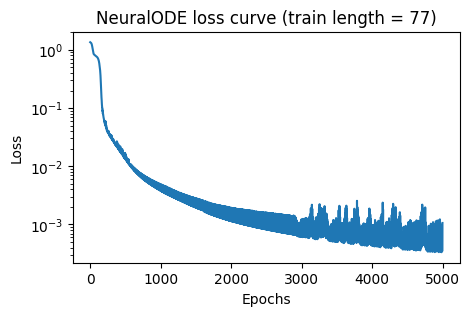

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(jnp.asarray(loss_history))
ax.set_yscale("log", base=10)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title(f"NeuralODE loss curve (train length = {chunk_length})")

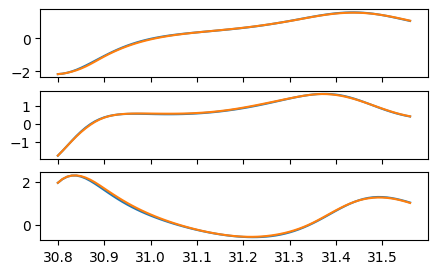

In [13]:
u_pred = solve_neuralode(model, t_train_batched, u_train_batched[:, 0])

chunk_idx = 40
fig, axes = plt.subplots(3, 1, figsize=(5, 3), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(t_train_batched[chunk_idx], u_train_batched[chunk_idx, :, i])
    ax.plot(t_train_batched[chunk_idx], u_pred[chunk_idx, :, i])

In [14]:
u_pred_test = solve_ode(model.rhs, t, u_test[0], max_steps=None)

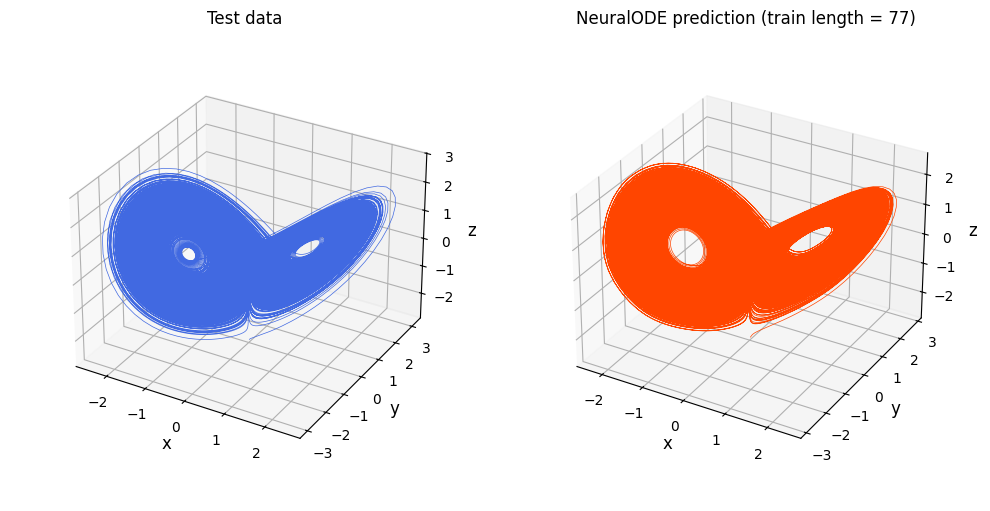

In [18]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    constrained_layout=True,
    subplot_kw={"projection": "3d"},
)
plot_kwargs = {"linewidth": 0.5}
axes[0].plot(*u_test.T, color="royalblue", **plot_kwargs)
axes[0].set_title("Test data")
axes[1].plot(*u_pred_test.T, color="orangered", **plot_kwargs)
axes[1].set_title(f"NeuralODE prediction (train length = {chunk_length})")
for ax in axes:
    set_labels(ax, ["x", "y", "z"], fontsize="large")
    ax.set_box_aspect(None, zoom=0.85)